In [42]:
using JuMP
using Ipopt
using CSV
using GraphRecipes, Plots
using LightGraphs
using LinearAlgebra
using SparseArrays
using DataFrames
using Juniper, Alpine, BARON

In [43]:
innovations = CSV.File("./innovations.csv",header=1,delim=",") |> DataFrame
mapki = CSV.File("./map-ki.csv",header=1,delim=",") |> DataFrame
compromise = CSV.File("./compromise.csv",header=1,delim=",") |> DataFrame
initial = CSV.File("./initial.csv",header=1,delim=",") |> DataFrame
ci=innovations[!,2]
rl=innovations[!,3]


5-element Vector{Int64}:
 2
 3
 1
 3
 1

In [44]:
#using Pkg;
#Pkg.build("BARON")

In [45]:
function get_transition_mat(i)
    p_mat=reshape(collect(innovations[i,9:33]),5,5)
    return p_mat
end


function get_rate_mat(i)
    p_mat=get_transition_mat(i)
    q_mat=300*p_mat.*collect(innovations[i,4:8])'
    for i in 1:5
        q_mat[i,i]=-1*sum(q_mat[i,j] for j in 1:5 if j!=i)
    end
    return q_mat
end

function get_IAM_factor(t)
    return 1
end

function calc_tot_co2(x,t)
    return 100
end

function get_RL_atT(i,t)
    s0=[0 0 0 0 0 ]
    s0[i]=rl[i]
    q=get_rate_mat(i)
    #rl_t=sum([1 2 3 4 5].*(s0*exp(q*t)))
    rl_t=sum([1 2 3 4 5].*(s0*(I+t*q+1/2*t^2*q)))
    return rl_t
end

get_RL_atT (generic function with 1 method)

In [46]:
function tech_roadmap()
    rdmap=Model(BARON.Optimizer)
    @variable(rdmap,yk[k=1:nrow(compromise)],Bin)
    @variable(rdmap,0 ≤ tk[k=1:nrow(compromise)] ≤ 50)
    @variable(rdmap,0 ≤ xk[k=1:nrow(compromise)] ≤ 1)
    @variable(rdmap,yi[i=1:nrow(innovations)],Bin)
    @variable(rdmap,0 ≤ ti[i=1:nrow(innovations)] ≤ 50)
    @variable(rdmap, 1 ≤ s[i=1:nrow(innovations)] ≤ 5)
    
    @variable(rdmap, co2_2050 ≥ 0)
    @variable(rdmap, co2_total ≥ 0)
    
    @constraint(rdmap, [i=1], sum(yk[k] for k=1:mapki[i,2])==yi[i])
    @constraint(rdmap, [i=2:nrow(mapki)], sum(yk[k] for k=mapki[i-1,2]:mapki[i,2])==yi[i])
    
    @constraint(rdmap, [i=1,k=1:mapki[i,2]], ti[i] ≤ tk[k])
    @constraint(rdmap, [i=2:nrow(mapki),k=mapki[i-1,2]:mapki[i,2]], ti[i] ≤ tk[k])
    
    @constraint(rdmap, [i=1:nrow(mapki)], 50*yi[i] ≥ ti[i])
    @constraint(rdmap, [k=1:nrow(compromise)], 50*yk[k] ≥ tk[k])
    
    @constraint(rdmap, [k=1:nrow(compromise)], yk[k] ≥ xk[k])
    @constraint(rdmap, sum(xk[k] for k in 1:nrow(compromise)) ≤ 1) 
    
    
    @constraint(rdmap, co2_2050==sum(xk[k]*compromise[k,3]*get_IAM_factor(tk[k]) for k in 1:nrow(compromise))
        + (1-sum(xk[k] for k in 1:nrow(compromise)))*initial[1,3])
    
    @constraint(rdmap, co2_total == calc_tot_co2(xk,tk))
    
    @constraint(rdmap, [i=1:nrow(innovations)], s[i]==get_RL_atT(i,ti[i]))
    
    dummy=10
    @objective(rdmap,Min,dummy)
    
    optimize!(rdmap)
    return JuMP.value.(yk)  
end

tech_roadmap (generic function with 1 method)

In [47]:
y=tech_roadmap()

LoadError: IOError: could not spawn `/home/thakker.8/.local/share/baron-lin64/baron: /tmp/jl_EFqeyw/baron_problem.bar`: no such file or directory (ENOENT)

In [6]:
innovations

,i,Cost_per_RL,RL,Sojourn1,Sojourn2,Sojourn3,Sojourn4,Sojourn5,P11
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Int64
1,1,92,2,4.6,1.34,2.04,0.12,8.86,0
2,2,122,3,8.32,8.84,0.65,9.9,9.65,0
3,3,78,1,4.44,1.21,5.09,6.52,8.67,0
4,4,131,3,5.48,7.62,3.34,5.05,5.6,0
5,5,95,1,9.94,2.38,7.94,3.82,5.44,0


In [7]:
i=1
eDtmc=[[collect(innovations[i,9:13])],[collect(innovations[i,9:13])]]

2-element Vector{Vector{Vector{Real}}}:
 [[0, 0.76, 0.21, 0.03, 0]]
 [[0, 0.76, 0.21, 0.03, 0]]

In [8]:
innovations[1,9:13]

,P11,P12,P13,P14,P15
,Int64,Float64,Float64,Float64,Int64
1,0,0.76,0.21,0.03,0


In [9]:
collect(innovations[i,9:13])

5-element Vector{Real}:
 0
 0.76
 0.21
 0.03
 0

In [10]:
g=get_rate_mat(3)

5×5 Matrix{Float64}:
 -3.14283    1.31043   1.8324     0.0        0.0
 10.0699   -13.413     3.06927    0.27384    0.0
  2.54412    2.12355  -8.57967    3.912      0.0
  0.70596    0.19602   9.74226  -36.6542    26.01
  0.0        0.0       0.62607   15.3742   -16.0002

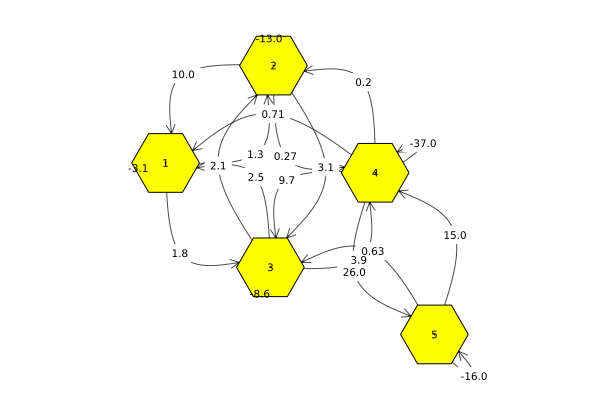

In [11]:
n = 5
edgelabel_dict = Dict()
edgelabel_mat = Array{String}(undef, n, n)
for i in 1:n
    for j in 1:n
        edgelabel_mat[i, j] = edgelabel_dict[(i, j)] = string(round(g[i,j],sigdigits=2)) 
    end
end
edgelabel_vec = edgelabel_mat[:]


graphplot(g, names=1:5, curvature_scalar=0.2,  edgelabel=edgelabel_dict, markersize = 0.5,
           linecolor = :darkgrey, markercolor = "yellow",
           linealpha = 0.7)

In [12]:
tt=4
g+tt*g^2/2+tt^3*g^3/6+tt^4*g^4/24

5×5 Matrix{Float64}:
   36089.9        -31786.2        …       1.7473e5      -1.28173e5
 -356029.0             4.45167e5     -22321.8        37871.5
   76634.2            -1.54644e5         -4.36827e6      3.35247e6
      -1.98728e5       3.70627e5          4.55057e7     -3.534e7
   84409.8            -1.24455e5         -2.08083e7      1.61904e7

In [13]:
exp(g*tt)

5×5 Matrix{Float64}:
 0.47519   0.0842387  0.231492  0.0796313  0.129449
 0.475189  0.0842387  0.231492  0.0796314  0.129449
 0.475187  0.0842385  0.231492  0.079632   0.12945
 0.475185  0.0842384  0.231492  0.0796326  0.129451
 0.475185  0.0842383  0.231493  0.0796328  0.129452

In [14]:
get_RL_atT(1,10)

351.9200000000001

In [15]:
q=get_rate_mat(3)
t=5

5

In [16]:
(I+t*q+1/2*t^2*q)

5×5 Matrix{Float64}:
 -53.9995    22.9325     32.067      0.0        0.0
 176.224   -233.728      53.7122     4.7922     0.0
  44.5221    37.1621   -149.144     68.46       0.0
  12.3543     3.43035   170.49    -640.449    455.175
   0.0        0.0        10.9562   269.048   -279.004

In [17]:
q_mat=get_transition_mat(i).*collect(innovations[1,4:8])'

5×5 Matrix{Float64}:
 0.0    0.4824  0.2448  0.0    0.0
 3.496  0.0     0.408   0.0    0.0
 0.966  0.7772  0.0     0.024  0.0
 0.138  0.0804  1.326   0.0    8.86
 0.0    0.0     0.0612  0.096  0.0

In [18]:
get_transition_mat(i)

5×5 Matrix{Real}:
 0     0.36  0.12  0    0
 0.76  0     0.2   0.0  0
 0.21  0.58  0     0.2  0
 0.03  0.06  0.65  0    1
 0     0     0.03  0.8  0

In [19]:
collect(innovations[1,4:8])

5-element Vector{Float64}:
 4.6
 1.34
 2.04
 0.12
 8.86

In [20]:
get_transition_mat(i)

5×5 Matrix{Real}:
 0     0.36  0.12  0    0
 0.76  0     0.2   0.0  0
 0.21  0.58  0     0.2  0
 0.03  0.06  0.65  0    1
 0     0     0.03  0.8  0

In [29]:
q*6

5×5 Matrix{Float64}:
 -18.857      7.86258   10.9944      0.0        0.0
  60.4195   -80.4782    18.4156      1.64304    0.0
  15.2647    12.7413   -51.478      23.472      0.0
   4.23576    1.17612   58.4536   -219.925    156.06
   0.0        0.0        3.75642    92.245    -96.0014

In [58]:
q=get_rate_mat(1)

5×5 Matrix{Float64}:
 -218.16    144.72    73.44      0.0      0.0
 1048.8   -1171.2    122.4       0.0      0.0
  289.8     233.16  -530.16      7.2      0.0
   41.4      24.12   397.8   -3121.32  2658.0
    0.0       0.0     18.36     28.8    -47.16

In [59]:
exp(q*9)

5×5 Matrix{Float64}:
 0.721822  0.114715  0.128138  0.000615839  0.0347095
 0.721822  0.114715  0.128138  0.000615839  0.0347095
 0.721822  0.114715  0.128138  0.000615839  0.0347095
 0.721822  0.114715  0.128138  0.000615839  0.0347095
 0.721822  0.114715  0.128138  0.000615839  0.0347095

In [60]:
t=7

7

In [61]:
I+t*+t^2*q^2/2+t^3*q^3/6+t^4*q^4/24+t^5*q^5/120+t^6*q^6/720+t^7*q^7/5040

5×5 Matrix{Float64}:
 -1.09902e23   1.17128e23  -2.831e21    -3.10497e22   2.66548e22
  9.55603e23  -1.02558e24   8.00398e22  -6.82682e22   5.82016e22
 -2.39071e23   2.65252e23  -2.21909e23   1.37213e24  -1.1764e24
  7.14552e23  -2.51398e24   7.24031e25  -4.95273e26   4.2467e26
 -2.82463e21   1.90843e22  -6.71049e23   4.59326e24  -3.93847e24

In [66]:
a=[1 2; 1 1]

2×2 Matrix{Int64}:
 1  2
 1  1

In [71]:
a^3

2×2 Matrix{Int64}:
 7  10
 5   7

In [68]:
a.^2

2×2 Matrix{Int64}:
 1  4
 1  1